## Column numbering scheme ##
*For accessing results in this notebook, you must use 0-based indexing i.e. column number - 1*
1. query_name
2. seed eggNOG ortholog
3. seed ortholog evalue
4. seed ortholog score
5. Predicted taxonomic group
6. Predicted protein name
7. Gene Ontology terms 
8. EC number
9. KEGG_KO
10. KEGG_Pathway
11. KEGG_Module
12. KEGG_Reaction
13. KEGG_rclass
14. BRITE
15. KEGG_TC
16. CAZy 
17. BiGG Reaction
18. tax_scope: eggNOG taxonomic level used for annotation
19. eggNOG OGs 
20. bestOG (deprecated, use smallest from eggnog OGs)
21. COG Functional Category 
22. eggNOG free text description

## COG Functional Categories Descriptions ##
A	RNA processing and modification

B	Chromatin Structure and dynamics

C	Energy production and conversion

D	Cell cycle control and mitosis

E	Amino Acid metabolism and transport

F	Nucleotide metabolism and transport

G	Carbohydrate metabolism and transport

H	Coenzyme metabolis

I	Lipid metabolism

J	Tranlsation

K	Transcription

L	Replication and repair

M	Cell wall/membrane/envelop biogenesis

N	Cell motility

O	Post-translational modification, protein turnover, chaperone functions

P	Inorganic ion transport and metabolism

Q	Secondary Structure

T	Signal Transduction

U	Intracellular trafficing and secretion

Y	Nuclear structure

Z	Cytoskeleton

R	General Functional Prediction only

S	Function Unknown

In [1]:
### Import Required Libraries ###
### Most of these are available via anaconda, others can be installed via pip or bioconda ###
import pandas as pd
import numpy as np
import collections as collect
import glob 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MultiLabelBinarizer
from bioservices import kegg

# Functions for parsing eggNOG Results #

In [2]:
def parse_annotations(indir):
    return glob.glob(os.path.join(indir, "**/*.annotations"))

In [4]:
def read_annotations(filein):
    """ 
    Function for reading a EggNOG-MapperV2 annotations file to a table format
    Input: path to annotations file
    Output: dataframe of annotations table
    """
    names = ["query_name", "seed_ortholog", "evalue", "score", "predicted_taxa", "predicted_name", 
             "GO", "EC", "KEGG_KO","KEGG_Pathway", "KEGG_Module","KEGG_Reaction", "KEGG_rclass", "BRITE",
             "KEGG_TC", "CAZy", "BiGG Reaction", "tax_scope", "eggNOG_OGs", "best_OG", "COG_Category", "description"]
    df = pd.read_csv(filein, comment="#", sep = "\t", names = names)
    #df.KEGG_KO.replace("ko:", "",regex=True, inplace=True) #the KO: is not a real part of the accession
    #df = df.replace("ko:", "", inplace=True)
    return df

In [5]:
def get_cogs(df, normalization):
    """
    Function for reading an annotations file and extracting the functional 
    annotations. 
    Input: 
        df: Dataframe of eggNOG-V2 annotations file
        normalization: {"all", "named"}
    Output: Dictionary structure of the counts of each eggNOG function
    """
    ### make an empty list ###
    cog_strings = []
    length_df = len(df)
    ### Count the total number of annotations before dropping NaN for one form of normalization ###
    cog_col = df.iloc[:,20].dropna()
    #print(cog_col)
    for row in cog_col:
        ### Take all cog categories from a proteins entry ###
        #print(row)
        row_items = list(row)
        #print(row_items)
        for item in row_items:
            cog_strings.append(item) ## add to list of strings ##
    
    output = collect.Counter(cog_strings) ## count the number of each type
    
    alphabet=["A","B","C","D","E","F","G","H","I",
              "J","K","L","M","N","O","P","Q","R","S",
              "T","U","V","W","X","Y","Z"]
    
    for letter in alphabet:
        if letter not in output.keys(): ## check to see if letter is in the counts
            output[letter] = 0 ## if not add to the dictionary and keep count as zero. 
    
    sorted_output = dict()
    
    if normalization == "all":
        total = length_df
    elif normalization == "named":
        total = sum(output.values())
    else: 
        raise Exception("normalization must be 'named' or 'all'")
    for letter in alphabet:
        sorted_output[letter] = round((output[letter] / total) * 100, 3)
    
    return sorted_output 
    
        

In [6]:
def collect_eggnog_annotations(files, normalization):
    """
    Will go through each folder in the directory, and 
    look for .annotation files, and save them to the name of the folder they correspond to (genome name)
    """
    #os.cd(dir_path) ## change user to eggnog data folder from current path
    genomes = dict()
    for folder in files:
        genome_name = folder.split("/")[-2]
        genomes[genome_name] = get_cogs(read_annotations(folder), normalization)
    return genomes


In [7]:
def pileup(files, column="eggNOG", output_type="default", skip_multi=False):
    #https://stackoverflow.com/questions/51538480/dictionary-to-dataframe-presence-absence
    """
    Parse through directory folders and retrieve annotation files
    Args:
        column: column 0-based to pileup on
    INFO:
    KO: 0-based index is 8,
    EggNOG_Names: 0-based index is 5, Note use description dictionary function for this
    KEGG Reaction: 0-based is 11
    returns a dataframe compatible with upsetR or upsetPython.
    """
    genomes = dict()
    eggnog_annots = files 
    ### Scrape through each annotation file ###
    for folder in eggnog_annots:
        genome_name = folder.split("/")[-2]
        if column == "eggNOG":
            df = read_annotations(folder)
            df["Key"] = df.seed_ortholog.astype(str) + "//" + df.predicted_taxa.astype(str)+ "//" + df.predicted_name.astype(str) +\
            "//"+df.description.astype(str)+"//"+df.COG_Category.astype(str)
            accessions = df.Key
        else:
            accessions = []
            entries = list(read_annotations(folder).iloc[:,column].dropna()) #get specified column
            ### Parse through each row of column ###
            for entry in entries:
                items = entry.split(",")
                ### Breakup entries that are lists of more than one accession, or skip them ###
                if (len(items) > 1) and (skip_multi == False):
                    for i in items:
                        accessions.append(i)
                elif (len(items) > 1) and (skip_multi == True):
                    continue
                else:
                    accessions.append(entry)
        genomes[genome_name] = accessions
        
    if output_type == "default": # output lists of accessions per genome
        output = pd.DataFrame.from_dict(genomes, orient="index").fillna("NaN")
        output = output.transpose()
        
    elif output_type == "count": # output counts of each accession per genome
        output = pd.DataFrame({k:collect.Counter(v) for k, v in genomes.items()}).fillna(0).astype(int)
    
    elif output_type == "indicator": # output binary table of each accession per genome (1 present, 0 absent)
        mlb = MultiLabelBinarizer()
        output = pd.DataFrame(mlb.fit_transform(genomes.values()),columns=mlb.classes_, index=genomes.keys()).transpose()
    
    return output 

In [8]:
def find_unique_genes(df, use_endophytes = True):
    space_pauci = ["Paucimobilis_FKI-L5-BR-P1", "Paucimobilis_LCT-SP1"]
    type_pauci = ["Paucimobilis_NCTC11030"]
    space_sang = ["Sanguinis_IIF7SW-B3A", "Sanguinis_IIF7SW-B5", "Sanguinis_ISS_IIF7SWP"]
    type_sang = ["Sanguinis_NBRC_13937"]
    endophytes = ["Sphingomonas_LK11"]
    space_genomes = space_sang + space_pauci
    type_genomes = type_sang + type_pauci
    all_genomes = space_pauci + type_pauci + space_sang + type_sang 
    present_all, unique_space_pauci, unique_space_sang, unique_all_space = [], [], [], []
    unique_endophytes = []
    for row in df.iterrows():
        results = row[1]
        ### Evaluate paucimobilis ###
        if any( [results[i] != 0 for i in space_pauci] ) and all( [results[j] == 0 for j in type_pauci] ):
            ### Here at least one space paucimobilis strain contained a protein not present in type strain ###
            unique_space_pauci.append(True)
        else:
            unique_space_pauci.append(False)

        ### Evaluate sanguinis ###
        if any( [results[i] != 0 for i in space_sang] ) and all( [results[j] == 0 for j in type_sang] ):
            unique_space_sang.append(True)
        else:
            unique_space_sang.append(False)
        ### Evaluate if each protein is present in each genome ###
        if all([results[i] != 0 for i in all_genomes]):
            present_all.append(True)
        else:
            present_all.append(False)
        
        ### Find proteins that are in all of the space genomes but not in the type strains ###
        if all( [results[i] != 0 for i in space_genomes]) and all([ results[j] == 0 for j in type_genomes ]):
            unique_all_space.append(True)
        else:
            unique_all_space.append(False)
        if use_endophytes == True:
            if all ([results[i] == 0 for i in all_genomes]) and all( [results[j] != 0 for j in endophytes] ):
                unique_endophytes.append(True)
            else:
                unique_endophytes.append(False)
                
    
    ### Add new Columns to dataframe ###
    df["Present_All"] = present_all
    df["Unique_Space_Paucimobilis"] = unique_space_pauci
    df["Unique_Space_Sanguinis"] = unique_space_sang
    df["Unique_Space_All"] = unique_all_space
                    
    if use_endophytes == True:
        df["Unique_LK11"] = unique_endophytes
    return df


# COG Functional Categories Hierarchical Clustering #

In [9]:
keep_lk11 = True
infiles = parse_annotations(".") #folder of annotations are present in the current directory 
genomes_names = [x.split("/")[-2] for x in infiles]
if keep_lk11 == False:
    infiles.remove("LK11")
    genomes_names.remove("LK11")
print(genomes_names)

['Paucimobilis_FKI-L5-BR-P1', 'Paucimobilis_LCT-SP1', 'Paucimobilis_NCTC11030', 'Sanguinis_IIF7SW-B3A', 'Sanguinis_IIF7SW-B5', 'Sanguinis_ISS_IIF7SWP', 'Sanguinis_NBRC_13937', 'Sphingomonas_LK11']


In [10]:
### Collect the COG functional Categories ###
genomes = collect_eggnog_annotations(infiles, "all")
#genomes = collect_eggnog_annotations("all")
#genomes
genome_df = pd.DataFrame(genomes)
genome_df

,Paucimobilis_FKI-L5-BR-P1,Paucimobilis_LCT-SP1,Paucimobilis_NCTC11030,Sanguinis_IIF7SW-B3A,Sanguinis_IIF7SW-B5,Sanguinis_ISS_IIF7SWP,Sanguinis_NBRC_13937,Sphingomonas_LK11
A,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B,0.049,0.053,0.053,0.057,0.051,0.050,0.055,0.059
C,5.358,5.637,5.366,4.999,5.216,5.253,5.163,5.401
D,1.204,1.064,1.175,1.136,1.074,1.101,1.049,1.187
E,6.709,6.780,6.941,6.930,6.290,6.303,6.737,7.003
F,1.769,1.835,1.789,1.846,1.713,1.676,1.767,1.929
G,5.579,6.009,6.060,6.220,5.702,5.653,5.964,6.291
H,3.637,3.696,3.737,3.692,3.375,3.352,3.506,3.798
I,3.858,3.802,3.497,3.664,3.477,3.502,3.617,3.501
J,4.325,4.493,4.485,4.771,4.372,4.302,4.666,5.074


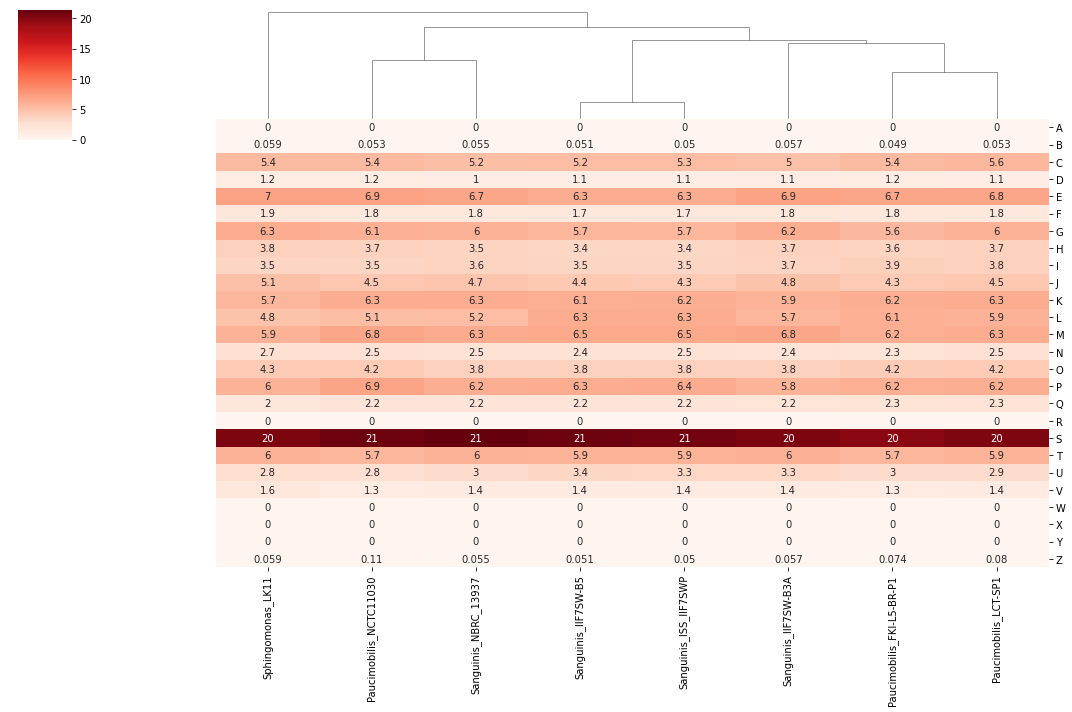

In [11]:
### Create a hierarchical cluster of results using average euclidean (or others) ###
cluster = sns.clustermap(genome_df, method="average", metric="euclidean", figsize= (15,10), row_cluster=False, annot = True,cmap="Reds")
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cluster.savefig("EggNOG_Functions_average_euclidean.svg")
cluster.savefig("EggNOG_Functions_average_euclidean.png")

# Parse Accession-Based columns for Intersection analysis #

### Retrieve KEGG Accessions and store in a dataframe for easier access, hashed because it is quite slow 

In [15]:
#s = kegg.KEGG() ##Access Bioservices (if you'd like)

In [ ]:
### Get accession names and descriptions from KEGG-related pileups, hashed since it takes awhile to retrieve
ko_res = s.list("ko", organism=None)
ko_list = str(ko_res)[2:-1].split("\\n") ## Remove starting and ending bytes
ko_rows = [i.split("\\t") for i in ko_list]
ko_descriptions = pd.DataFrame(ko_rows, columns = ["KO_ID","KO_Description"])
ko_descriptions.index = ko_descriptions.KO_ID
ko_descriptions.to_csv("KO_Descriptions.csv")

In [305]:
path_res = s.list("pathway", organism=None)

In [308]:
path_list = path_res.split("\n")
path_rows = [i.split("\t") for i in path_list]
path_descriptions = pd.DataFrame(path_rows, columns = ["Pathway_ID", "Pathway_Description"])
path_descriptions 
#path_descriptions.index = path_descriptions.Pathway_ID
#path_descriptions.to_csv("Pathway_Descriptions.csv")

In [ ]:
brite = s.list("")

In [259]:
y = list(pileup(infiles,8,output_type="count").index)
x = y[:5]
kos = []
names = []
descriptions = []
for i in x:
    entries = s.get(i).strip().split("\t")
    print(entries)
    #ko,desc = entries[0].replace("ko:",""), entries[1]
    

['ENTRY       K07653                      KO\nNAME        mprB\nDEFINITION  two-component system, OmpR family, sensor histidine kinase MprB [EC:2.7.13.3]\nPATHWAY     ko02020  Two-component system\nBRITE       KEGG Orthology (KO) [BR:ko00001]\n             09130 Environmental Information Processing\n              09132 Signal transduction\n               02020 Two-component system\n                K07653  mprB; two-component system, OmpR family, sensor histidine kinase MprB\n             09180 Brite Hierarchies\n              09181 Protein families: metabolism\n               01001 Protein kinases\n                K07653  mprB; two-component system, OmpR family, sensor histidine kinase MprB\n              09183 Protein families: signaling and cellular processes\n               02022 Two-component system\n                K07653  mprB; two-component system, OmpR family, sensor histidine kinase MprB\n            Enzymes [BR:ko01000]\n             2. Transferases\n              2.7  Transf

['ENTRY       K18351                      KO\nNAME        vanSAc\nDEFINITION  two-component system, OmpR family, sensor histidine kinase VanS [EC:2.7.13.3]\nPATHWAY     ko01502  Vancomycin resistance\n            ko02020  Two-component system\nMODULE      M00651  Vancomycin resistance, D-Ala-D-Lac type\nBRITE       KEGG Orthology (KO) [BR:ko00001]\n             09130 Environmental Information Processing\n              09132 Signal transduction\n               02020 Two-component system\n                K18351  vanSAc; two-component system, OmpR family, sensor histidine kinase VanS\n             09160 Human Diseases\n              09175 Drug resistance: antimicrobial\n               01502 Vancomycin resistance\n                K18351  vanSAc; two-component system, OmpR family, sensor histidine kinase VanS\n             09180 Brite Hierarchies\n              09181 Protein families: metabolism\n               01001 Protein kinases\n                K18351  vanSAc; two-component system, Omp

["ENTRY       K01607                      KO\nNAME        pcaC\nDEFINITION  4-carboxymuconolactone decarboxylase [EC:4.1.1.44]\nPATHWAY     ko00362  Benzoate degradation\n            ko01100  Metabolic pathways\n            ko01120  Microbial metabolism in diverse environments\n            ko01220  Degradation of aromatic compounds\nBRITE       KEGG Orthology (KO) [BR:ko00001]\n             09100 Metabolism\n              09111 Xenobiotics biodegradation and metabolism\n               00362 Benzoate degradation\n                K01607  pcaC; 4-carboxymuconolactone decarboxylase\n            Enzymes [BR:ko01000]\n             4. Lyases\n              4.1  Carbon-carbon lyases\n               4.1.1  Carboxy-lyases\n                4.1.1.44  4-carboxymuconolactone decarboxylase\n                 K01607  pcaC; 4-carboxymuconolactone decarboxylase\nDBLINKS     RN: R03470\n            COG: COG0599\n            GO: 0047575\nGENES       QSU: 112006196\n            PAN: PODANSg169\n            

['ENTRY       K00799                      KO\nNAME        GST, gst\nDEFINITION  glutathione S-transferase [EC:2.5.1.18]\nPATHWAY     ko00480  Glutathione metabolism\n            ko00980  Metabolism of xenobiotics by cytochrome P450\n            ko00982  Drug metabolism - cytochrome P450\n            ko00983  Drug metabolism - other enzymes\n            ko01100  Metabolic pathways\n            ko01524  Platinum drug resistance\n            ko04212  Longevity regulating pathway - worm\n            ko05200  Pathways in cancer\n            ko05204  Chemical carcinogenesis\n            ko05225  Hepatocellular carcinoma\n            ko05418  Fluid shear stress and atherosclerosis\nBRITE       KEGG Orthology (KO) [BR:ko00001]\n             09100 Metabolism\n              09106 Metabolism of other amino acids\n               00480 Glutathione metabolism\n                K00799  GST, gst; glutathione S-transferase\n              09111 Xenobiotics biodegradation and metabolism\n               00

In [192]:
names = ["GO","EC","KEGG:KO","KEGG:Pathway","KEGG:Module","KEGG:Reaction"]
cols = [6,7,8,9,10,11]
names = ["KEGG:KO"]
cols = [8,9]
for i,j in zip(names,cols):
    names, descriptions = [], []
    df = pileup(infiles,column=j,output_type="count")
    if j == 8:
        df["KO"] = df.index
        for row in df.iterrows():
            row = row[1]
            ko = s.get(row.KO).split("\n")
            name,description = ko[1].replace("NAME", ""), ko[2].replace("DEFINITION", "")
            names.append(name); descriptions.append(description)
        df["ID_Name"] = names
        df["ID_Description"] = descriptions
df

KeyboardInterrupt: 

['NAME        mprB',
 'DEFINITION  two-component system, OmpR family, sensor histidine kinase MprB [EC:2.7.13.3]']

# Parsing Annotations For Intersection Analysis of EggNOG OGs #

In [101]:
df = pileup(infiles, column="eggNOG", output_type="count") ## Grab the eggNOG proteins names 
df["Key"] = df.index
df[['Seed', 'Taxa','Name', "Description", "Category"]] = df.Key.str.split("//", expand=True)
df = df.drop("Key", axis=1)
df = df.reset_index(drop=True)
df["Key"] = df.Taxa + ":" + df.Name + ":" + df.Description + ":" + df.Category
new_columns = ["Key", "Seed","Category","Taxa","Name","Description"] + genomes_names
eggNOG = df[new_columns]

In [102]:
eggNOG

,Key,Seed,Category,Taxa,Name,Description,Paucimobilis_FKI-L5-BR-P1,Paucimobilis_LCT-SP1,Paucimobilis_NCTC11030,Sanguinis_IIF7SW-B3A,Sanguinis_IIF7SW-B5,Sanguinis_ISS_IIF7SWP,Sanguinis_NBRC_13937,Sphingomonas_LK11
0,Sphingomonadales:nan:Histidine kinase-like ATP...,1007104.SUS17_3789,T,Sphingomonadales,nan,Histidine kinase-like ATPases,2,1,1,0,0,0,0,0
1,Sphingomonadales:nan:Transcriptional regulator...,1007104.SUS17_3788,T,Sphingomonadales,nan,"Transcriptional regulatory protein, C terminal",1,1,1,0,0,0,0,0
2,Sphingomonadales:nan:nan:nan,1219049.SP5_104_00060,nan,Sphingomonadales,nan,nan,1,1,1,1,1,1,1,0
3,Sphingomonadales:nan:Enoyl-(Acyl carrier prote...,1007104.SUS17_2447,IQ,Sphingomonadales,nan,Enoyl-(Acyl carrier protein) reductase,1,1,1,0,0,0,0,0
4,Sphingomonadales:cybB:Prokaryotic cytochrome b...,1007104.SUS17_2446,C,Sphingomonadales,cybB,Prokaryotic cytochrome b561,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,Sphingomonadales:eriC:Voltage gated chloride c...,1549858.MC45_18290,P,Sphingomonadales,eriC,Voltage gated chloride channel,0,0,0,0,0,0,0,1
8723,Sphingomonadales:crcB:Important for reducing f...,392499.Swit_2801,U,Sphingomonadales,crcB,Important for reducing fluoride concentration ...,0,0,0,0,0,0,0,1
8724,Sphingomonadales:ino1:Inositol-3-phosphate syn...,1090320.KB900605_gene2077,I,Sphingomonadales,ino1,Inositol-3-phosphate synthase,0,0,0,0,0,0,0,1
8725,Sphingomonadales:tnpS:Phage integrase family:L,13690.CP98_04085,L,Sphingomonadales,tnpS,Phage integrase family,0,0,0,0,0,0,0,1


In [106]:
### To make viewing easier, since multiple seeds map to a taxa:name combination, ###
### with slightly different descriptions, aggregate counts for simpler viewing ###
if keep_lk11 == False:
    eggNOG = eggNOG.groupby("Key").agg({"Seed": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Taxa": "first",
                                        "Name": "first",
                                        "Category": lambda x: "".join(str(i) for i in np.unique(x)), 
                                        "Description": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Paucimobilis_FKI-L5-BR-P1": lambda x: sum(x), 
                                        "Paucimobilis_LCT-SP1": lambda x: sum(x),
                                        "Paucimobilis_NCTC11030": lambda x: sum(x), 
                                        "Sanguinis_IIF7SW-B3A": lambda x: sum(x),
                                        "Sanguinis_IIF7SW-B5": lambda x: sum(x), 
                                        "Sanguinis_ISS_IIF7SWP": lambda x: sum(x),
                                        "Sanguinis_NBRC_13937": lambda x: sum(x)})
if keep_lk11 == True:
    eggNOG = eggNOG.groupby("Key").agg({"Seed": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Taxa": "first",
                                        "Name": "first",
                                        "Category": lambda x: "".join(str(i) for i in np.unique(x)), 
                                        "Description": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Paucimobilis_FKI-L5-BR-P1": lambda x: sum(x), 
                                        "Paucimobilis_LCT-SP1": lambda x: sum(x),
                                        "Paucimobilis_NCTC11030": lambda x: sum(x), 
                                        "Sanguinis_IIF7SW-B3A": lambda x: sum(x),
                                        "Sanguinis_IIF7SW-B5": lambda x: sum(x), 
                                        "Sanguinis_ISS_IIF7SWP": lambda x: sum(x),
                                        "Sanguinis_NBRC_13937": lambda x: sum(x),
                                        "Sphingomonas_LK11": lambda x: sum(x)})

In [107]:
output_eggNOG = find_unique_genes(eggNOG)
output_eggNOG

,Seed,Taxa,Name,Category,Description,Paucimobilis_FKI-L5-BR-P1,Paucimobilis_LCT-SP1,Paucimobilis_NCTC11030,Sanguinis_IIF7SW-B3A,Sanguinis_IIF7SW-B5,Sanguinis_ISS_IIF7SWP,Sanguinis_NBRC_13937,Sphingomonas_LK11,Present_All,Unique_Space_Paucimobilis,Unique_Space_Sanguinis,Unique_Space_All,Unique_LK11
Key,,,,,,,,,,,,,,,,,,
Acidithiobacillales:yoqW:SOS response associated peptidase (SRAP):S,1123368.AUIS01000006_gene572,Acidithiobacillales,yoqW,S,SOS response associated peptidase (SRAP),0,0,0,0,0,0,1,0,False,False,False,False,False
Acidobacteria:nan:RHS Repeat:M,682795.AciX8_3261,Acidobacteria,nan,M,RHS Repeat,0,0,3,1,1,1,1,0,False,False,False,False,False
Acidobacteriia:glf:UDP-galactopyranose mutase:M,240015.ACP_0182,Acidobacteriia,glf,M,UDP-galactopyranose mutase,0,1,0,0,0,0,0,0,False,True,False,False,False
Acidobacteriia:rfbX:Polysaccharide biosynthesis protein:S,240015.ACP_0043,Acidobacteriia,rfbX,S,Polysaccharide biosynthesis protein,0,1,0,0,0,0,0,0,False,True,False,False,False
Acidobacteriia:yagU:Protein of unknown function (DUF1440):S,278963.ATWD01000001_gene4411,Acidobacteriia,yagU,S,Protein of unknown function (DUF1440),1,0,0,0,0,0,0,0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unclassified Burkholderiales:cbpA:heat shock protein DnaJ:O,987059.RBXJA2T_02467,unclassified Burkholderiales,cbpA,O,heat shock protein DnaJ,0,0,0,0,0,0,0,1,False,False,False,False,True
unclassified Burkholderiales:eno:Catalyzes the reversible conversion of 2- phosphoglycerate into phosphoenolpyruvate. It is essential for the degradation of carbohydrates via glycolysis:G,1158292.JPOE01000002_gene1514,unclassified Burkholderiales,eno,G,Catalyzes the reversible conversion of 2- phos...,0,0,0,0,0,0,1,1,False,False,False,False,False
unclassified Burkholderiales:nan:Glycosyl transferases group 1:M,983917.RGE_10770,unclassified Burkholderiales,nan,M,Glycosyl transferases group 1,0,0,0,1,1,1,0,0,False,False,True,False,False


In [108]:
output_eggNOG[output_eggNOG["Unique_Space_All"] == True ]

,Seed,Taxa,Name,Category,Description,Paucimobilis_FKI-L5-BR-P1,Paucimobilis_LCT-SP1,Paucimobilis_NCTC11030,Sanguinis_IIF7SW-B3A,Sanguinis_IIF7SW-B5,Sanguinis_ISS_IIF7SWP,Sanguinis_NBRC_13937,Sphingomonas_LK11,Present_All,Unique_Space_Paucimobilis,Unique_Space_Sanguinis,Unique_Space_All,Unique_LK11
Key,,,,,,,,,,,,,,,,,,
Sphingomonadales:traG:Conjugal transfer protein TraG:U,1114964.L485_07150 // 1122970.AUHC01000017_gen...,Sphingomonadales,traG,U,Conjugal transfer protein TraG,1,1,0,1,1,1,0,0,False,True,True,True,False
Sphingomonadales:trbE:type IV secretion system:U,1114964.L485_07115 // 1122970.AUHC01000017_gen...,Sphingomonadales,trbE,U,type IV secretion system,1,1,0,1,1,1,0,0,False,True,True,True,False
Sphingomonadales:trbL:transfer protein trbL:U,1114964.L485_07100 // 13689.BV96_04141 // 1585...,Sphingomonadales,trbL,U,transfer protein trbL,1,1,0,2,1,1,0,0,False,True,True,True,False


In [109]:
output_eggNOG.to_csv("Final_EggNOG_Table_4.csv", index=True)